In [ ]:
from pathlib import Path
import librosa
import torch
import torch.nn as nn
import os
from fastspeech.visualize import show_mel
from fastspeech.data import load_audio, melspectrogram, get_audio_files

In [ ]:
path_data = Path('../../data/LJSpeech-1.1/wavs')

In [ ]:
file_name = 'LJ026-0155'

In [ ]:
path_text = path_data/(file_name+'.lab')

In [ ]:
path_audio = path_data/(file_name+'.wav')
sr = 22050

In [ ]:
audio = load_audio(path_audio, sr)

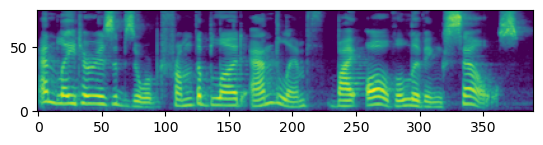

In [ ]:
show_mel(melspectrogram(audio))

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from fastai.data.transforms import FileGetter

In [ ]:
def get_lab_files(path_data):
    return FileGetter(extensions='.lab')(path_data)

In [ ]:
from typing import Callable, Sequence, Any

In [ ]:
class Transform:
    def __init__(self, functions: Sequence[Callable] = []) -> None:
        self.fns = functions
    
    def add(self, fn: Callable) -> None:
        self.fns.append(fn)
    
    def __call__(self, x: Any) -> Any:
        for fn in self.fns:
            x = fn(x)
        return x

In [ ]:
class TextAudioDataset(Dataset):
    def __init__(self, path_data: str, sr: int, audio_transforms: Transform = None, 
                 text_transforms: Transform = None):
        self.path_data = tuple(zip(get_audio_files(path_data), get_lab_files(path_data)))
        self.audio_transforms, self.text_transforms = audio_transforms, text_transforms
        self.sr = sr
    
    def __len__(self):
        return len(self.path_data)
    
    def __getitem__(self, index):
        path_audio, path_text = self.path_data[index]
        audio, text = load_audio(path_audio, self.sr), Path(path_text).open().read()
        
        if self.audio_transforms:
            audio = self.audio_transforms(audio)
        if self.text_transforms:
            text = self.text_transforms(text)
        
        return audio, text

In [ ]:
from torch import tensor

In [ ]:
audio_transform = Transform([melspectrogram, tensor])

In [ ]:
ds = TextAudioDataset(path_data, sr, audio_transform)

In [ ]:
mel, text = ds[0]

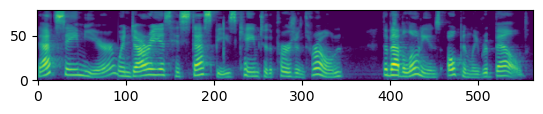

In [ ]:
show_mel(mel)

In [ ]:
mel_lengths, word_lengths, char_lengths = [], [], []

In [ ]:
for mel, text in ds:
    mel_lengths.append(mel.shape[-1])
    word_lengths.append(len(text.split(" ")))
    char_lengths.append(len(text))

KeyboardInterrupt: 

In [ ]:
import torch

In [ ]:
tensor(mel_lengths, dtype=torch.float).mean()

tensor(566.5582)

In [ ]:
import pandas as pd

In [ ]:
mel_lengths_t = tensor(mel_lengths)
word_lengths_t = tensor(word_lengths) 
char_lengths_t = tensor(char_lengths)

In [ ]:
lengths = tensor([mel_lengths, word_lengths, char_lengths])

In [ ]:
df = pd.DataFrame(data=lengths.T, columns=['mel_length', "word_length", "char_length"])

In [ ]:
df.head()

,mel_length,word_length,char_length
0,563,14,71
1,809,7,52
2,827,5,41
3,827,25,128
4,704,16,94


In [ ]:
df.mean()

mel_length     566.558248
word_length     16.984406
char_length     99.871656
dtype: float64

In [ ]:
df.std()

mel_length     188.270306
word_length      6.064107
char_length     33.956194
dtype: float64

In [ ]:
df.mean()[0] / df.mean()[1]

33.35755434538008

In [ ]:
df.mean()[0] / df.mean()[2]

5.6728632758294735

In [ ]:
mels, texts = [], []
for mel, text in ds:
    mels.append(mel)
    texts.append(text)

KeyboardInterrupt: 

In [ ]:
from fastai.text.all import *

In [ ]:
full_text = " ".join(texts)

In [ ]:
vocab_size = 1000

In [ ]:
def tokenizer(x: str) -> List:
    tokens = []
    for char in x:
        tokens.append(ord(char))
    
    return tokens

In [ ]:
tensor(tokenizer(text))

tensor([ 73, 116,  32, 119,  97, 115,  32, 110, 111, 116,  32,  97, 108, 119,
         97, 121, 115,  32, 101,  97, 115, 121,  32, 116, 111,  32, 104, 105,
        114, 101,  32,  97,  32, 104,  97, 110, 103, 109,  97, 110,  46])

In [ ]:
from math import sqrt
from torch.nn import Module

In [ ]:
def get_positional_embeddings(seq_len, # The length of the sequence
                              d_model, # The hidden dimension of the model
                              device: torch.device =None): # Device you want to use
    pos = torch.arange(d_model, device=device)[None, :]
    i = torch.arange(seq_len, device=device)[:, None]
    angle = pos / torch.pow(10000, 2 * i / d_model)
    pos_emb = torch.zeros(angle.shape, device=device)
    pos_emb[0::2,:], pos_emb[1::2,:] = angle[0::2,:].sin(), angle[1::2,:].cos()
    return pos_emb

In [ ]:
def scaled_dot_product(query: Tensor, key: Tensor, value: Tensor, mask: bool = False) -> Tensor:
    key_dim = key.shape[-1]

    scores = (query @ key.transpose(-1, -2)) / sqrt(key_dim)
    
    if mask:
        scores_mask = torch.tril(torch.ones_like(scores))
        scores = scores.masked_fill(scores_mask==0, float('-inf'))
        
    return F.softmax(scores, dim=-1) @ value

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, channels: int, mask: bool = False) -> None:
        super().__init__()
        self.linear = nn.Linear(channels, channels*3, bias=False)
        self.mask = mask
    
    def forward(self, x: Tensor) -> Tensor:
        h = self.linear(x)
        query, key, value = torch.chunk(h, chunks=3, dim=-1)
        
        attention_scores = scaled_dot_product(query, key, value, self.mask)
        
        return attention_scores

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_heads: int, mask: bool = False) -> None:
        super().__init__()
        self.attention_heads = nn.ModuleList([AttentionHead(in_channels, mask) for _ in range(n_heads)])
        
        self.linear = nn.Linear(in_channels*n_heads, out_channels)
    
    def forward(self, x: Tensor) -> Tensor:
        h = torch.cat([head(x) for head in self.attention_heads], dim=-1)
        
        return self.linear(h)

In [ ]:
def linear(in_channels: int, out_channels: int, Activation: Module = None, init: bool = True) -> Module:
    layers = [nn.Linear(in_channels, out_channels)]
    
    if Activation:
        layers.append(Activation())
    
    return nn.Sequential(*layers)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 hidden_channels: int, 
                 out_channels: int, 
                 n_hidden: int = 0, 
                 p_dropout: float = 0.,
                 Activation=nn.ReLU) -> None:
        super().__init__()
        self.in_layer = linear(in_channels, hidden_channels, Activation)
        
        self.hidden = nn.Sequential(*[linear(hidden_channels, hidden_channels, Activation) 
                                      for _ in range(n_hidden)])
        
        self.out_layer = linear(hidden_channels, out_channels, Activation=None)
        
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, x: Tensor) -> Tensor:
        h = self.in_layer(x)
        h = self.hidden(h)
        h = self.out_layer(h)
        return self.dropout(h)

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 hidden_channels: int, 
                 out_channels: int, 
                 n_heads: int, 
                 n_hidden_layers: int = 0,
                 p_dropout: float = 0.,
                 mask: bool = False) -> None:
        super().__init__()
        self.norm1 = nn.LayerNorm(in_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)
        
        self.attention = MultiHeadAttention(in_channels, hidden_channels, n_heads, mask)
        self.feed_forward = FeedForward(hidden_channels, hidden_channels, out_channels, n_hidden_layers, p_dropout)
    
    def forward(self, x: Tensor) -> Tensor:
        h = self.attention(self.norm1(x)) + x
        return self.feed_forward(self.norm2(h)) + h

In [ ]:
hidden_channels = 32
n_heads = 2
p = 0

In [ ]:
embedding_layer = nn.Embedding(128, hidden_channels)

In [ ]:
toks = tensor(tokenizer(text))

In [ ]:
t = embedding_layer(toks)[None,:]
t.shape

torch.Size([1, 41, 32])

In [ ]:
out = TransformerLayer(32, hidden_channels, hidden_channels, n_heads)(t)
out.shape

torch.Size([1, 41, 32])

In [ ]:
def get_padding(ks: int, dilation: int = 1) -> int:
    return ((ks - 1) // 2) * dilation

In [ ]:
x = out.transpose(-1,-2)
x.shape

torch.Size([1, 32, 125])

In [ ]:
for i in range(5):
    x = nn.ConvTranspose1d(hidden_channels, hidden_channels, 2, stride=2)(x)
    print(x.shape)

torch.Size([1, 32, 250])
torch.Size([1, 32, 500])
torch.Size([1, 32, 1000])
torch.Size([1, 32, 2000])
torch.Size([1, 32, 4000])


In [ ]:
m = mel
m = nn.Conv1d(80, hidden_channels, 5, padding=get_padding(5))(m)
m.shape

torch.Size([32, 531])

In [ ]:
for i in range(5):
    m = nn.Conv1d(hidden_channels, hidden_channels, 3, stride=2)(m)
    print(m.shape)

torch.Size([32, 265])
torch.Size([32, 132])
torch.Size([32, 65])
torch.Size([32, 32])
torch.Size([32, 15])


In [ ]:
torch.mean(m, dim=1).shape

torch.Size([32])